# Ising model configuration generator

Demonstration of multiplicative amplitude transduction using Qiskit

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *

In [2]:
import os
import sys
import math
import time
import collections
import numpy as np
import h5py
import matplotlib.pyplot as plt

#### Note about the next block
Lines below require `qiskit-qcgpu-provider`.
Version in PyPI is incompatible with the latest Qiskit (as of May 25 2020) so you'll need to clone [The source](https://github.com/qiskit-community/qiskit-qcgpu-provider) and do `pip install .`

In [3]:
#os.environ['PYOPENCL_CTX'] = '0'
#from qiskit_qcgpu_provider import QCGPUProvider
#QCGPU = QCGPUProvider()

## Function to create a common "params" dictionary

In [4]:
def get_params(lattice_side):
    params = dict()
    params['lattice_side'] = lattice_side
    n_spins = lattice_side ** 2
    params['n_spins'] = n_spins
    n_links = n_spins * 2 # periodic boundary condition
    sigma_max = n_links if (lattice_side % 2 == 0) else (n_links - 2 * lattice_side)
    params['sigma_max'] = sigma_max
    log2_data_depth = math.log2(sigma_max // 2) # energy always changes by 2 -> compress data
    nq_data = math.ceil(log2_data_depth)
    if nq_data == math.floor(log2_data_depth):
        nq_data += 1
    params['nq_data'] = nq_data

    return params

## Functions to inspect the state vector

In [5]:
def get_states(qc, backend=None, exc_args={}):
    if backend is None:
        backend = Aer.get_backend('statevector_simulator')
        #exc_args = {'backend_options': {'max_memory_mb': 12000}}
        
    job = execute(qc, backend, **exc_args)
    result = job.result()
    if not result.success:
        raise RuntimeError(result.results[0].status)
        
    return result.results[0].data.statevector

In [6]:
def print_states(params, states, group_by_spins=True, data_binary=False, filter_data=None, precision=2):
    lattice_side = params['lattice_side']
    n_spins = params['n_spins']
    nq_data = params['nq_data']

    anc_shift = n_spins + nq_data
    spin_mask = 2 ** n_spins - 1
    data_mask = 2 ** nq_data - 1

    data_binary_template = '{:0%db}' % nq_data

    spin_groups = collections.defaultdict(list)
    norm2 = 0.

    for i in range(states.shape[0]):
        v = states[i]
        if np.absolute(v) == 0.:
            continue

        if ((i >> anc_shift) % 2) != 1:
            print('Non-1 ancilla!!', ('{:0%db}:' % qc.num_qubits).format(i))
            continue

        spins = i & spin_mask
        data = (i >> n_spins) & data_mask

        if filter_data is not None and data not in filter_data:
            continue

        if data_binary:
            data = data_binary_template.format(data)

        spin_groups[spins].append((data, v))
        norm2 += np.square(np.absolute(v))

    state_template = '{:0%db}:' % n_spins
    float_template = '{:0.%df}' % precision
    N = states.shape[0]

    print('N =', N)

    for spins in sorted(spin_groups.keys()):
        state_str = state_template.format(spins).replace('0', 'o').replace('1', '+')
        for ipos in range(lattice_side, 0, -lattice_side):
            state_str = state_str[:ipos] + '\n' + state_str[ipos:]

        if group_by_spins:
            print(state_str[:-1])
            for data, v in spin_groups[spins]:
                print(('{} %s/sqrt(N) @ %spi' % (float_template, float_template)).format(data, np.absolute(v) * math.sqrt(N), np.angle(v) / np.pi))

        else:
            for data, v in spin_groups[spins]:
                print(('{}{} %s/sqrt(N) @ %spi' % (float_template, float_template)).format(state_str, data, np.absolute(v) * math.sqrt(states.shape[0]), np.angle(v) / np.pi))

    if filter_data is not None:
        print('Subspace norm', math.sqrt(norm2))

    print('-----')

In [7]:
try:
    import numba
except ImportError:
    def abs2(x):
        return np.square(np.absolute(x))
else:
    @numba.vectorize([numba.float64(numba.complex128), numba.float32(numba.complex64)])
    def abs2(x):
        return x.real**2 + x.imag**2

def get_norm(params, states, subspace_shift):
    nq_data = params['nq_data']

    states = states.reshape((-1, 2 ** nq_data, 2 ** subspace_shift))

    norm2 = np.sum(abs2(states[:, 0, :]))

    return math.sqrt(norm2)

## Functions for running experiments and counting the results

In [8]:
def get_counts(qc, backend=None, transpiled=False, shots=8192):
    if backend is None:
        backend = Aer.get_backend('qasm_simulator') # the device to run on
        
    if transpiled:
        qc_transpiled = qc
    else:
        qc_transpiled = transpile(qc, backend=backend, optimization_level=1)
        
    counts = collections.defaultdict(int)
    shots_remaining = shots
    shots_per_job = backend.configuration().max_shots
    jobs = []
    while shots_remaining > 0:
        jobs.append(execute(qc_transpiled, backend, shots=min(shots_remaining, shots_per_job)))
        shots_remaining -= shots_per_job

    while len(jobs) > 0:
        job = jobs[0]
        if job.in_final_state():
            jobs.pop(0)
            result = job.result()
            cnt = result.get_counts(qc)
            for key, value in cnt.items():
                counts[key] += value
                
    return counts

In [9]:
def get_efficiency(params, counts):
    # First nq_data bits of the key = measured value of D or E register
    nq_data = params['nq_data']

    hits = 0
    total = 0

    for key, value in counts.items():
        total += value
        if int(key[:nq_data], 2) == 0:
            hits += value

    return hits / total

In [10]:
def numpify_counts(counts):
    out = np.empty((len(counts), 2), dtype=np.int64)
    for ient, (key, value) in enumerate(counts.items()):
        out[ient][0] = int(key, 2)
        out[ient][1] = value
        
    return out

## Functions defining the circuit

In [11]:
def ising(params, K, namp=None, compute_norm=True, trans_only=False, measure=True, version=1):
    """
    Main function that defines the full circuit. Call with a params dictionary and the inverse temperature K.
    
    Args:
        params (dict): Circuit parameters.
        K (float): value of beta * J.
        namp (int): Specify the number of amplification iterations.
        compute_norm (bool): If True, computes the norm of the target state using the statevector simulator.
        trans_only (bool): If True, compose a circuit consisting of transduction and amplification only.
        measure (bool): If True, append the measurements at the end. Set to False if you wish to inspect the state vector.
        version (int):
            1 -> Write (Sigma_l - Sigma^min) in the data register and transduce the amplitudes as Prod_k [tan(atan(exp(K 2^k)))]^Sigma_l(k))
            2 -> Write (Sigma^max - Sigma_l) in the data register and transduce the amplitudes as Prod_k [tan(atan(exp(-K 2^k)))]^(-Sigma_l(k))
            3 -> Write (Sigma^max - Sigma_l) in the data register and transduce the amplitudes as Prod_k [cos(acos(exp(-K 2^k)))]^(-Sigma_l(k))
            Version 2 and 3 are in the paper ("direct" and "controlled" variants).
    """
    
    # Define the quantum circuit
    n_spins = params['n_spins']
    nq_data = params['nq_data']

    # Register for spin configurations
    state_register = QuantumRegister(n_spins, 'state')
    # D register
    data_register = QuantumRegister(nq_data, 'data')
    # Ancilla bit used to write spin pair counts to D
    anc_register = QuantumRegister(1, 'anc')
    # Measurement register
    mmt_register = ClassicalRegister(n_spins + nq_data, 'mmt')

    # Main circuit
    if version == 3:
        # E register
        crot_register = QuantumRegister(nq_data, 'crot')
        qc = QuantumCircuit(state_register, data_register, anc_register, crot_register, mmt_register)
    else:
        qc = QuantumCircuit(state_register, data_register, anc_register, mmt_register)

    # Make ancilla rotatable by U1
    qc.x(anc_register[0])

    if version == 1:
        loggamma_sign = 1.
        transduce_amplitude = transduce_tan
        subspace_shift = n_spins
        target_register = data_register
    elif version == 2:
        loggamma_sign = -1.
        transduce_amplitude = transduce_tan
        subspace_shift = n_spins
        target_register = data_register
    elif version == 3:
        loggamma_sign = -1.
        transduce_amplitude = transduce_cos
        subspace_shift = n_spins + nq_data + 1
        target_register = crot_register
        
    # Write spin pair counts to the data register
    if not trans_only:
        qc_write = write_data(params, qc, loggamma_sign)
        qc.extend(qc_write)
    # Transduce amplitudes from the content of the data register
    qc_transduce = transduce_amplitude(K, qc, loggamma_sign)
    qc.extend(qc_transduce)

    if namp is None or compute_norm:
        # Compute the norm of the target state to determine the number of necessary amplification iterations
        # (or just to print the norm)
        
        #os.environ['PYOPENCL_CTX'] = '0:0,1'
        #backend = QCGPU.get_backend('statevector_simulator')
        backend = None
        states = get_states(qc, backend=backend)
        norm = get_norm(params, states, subspace_shift)

        if namp is None:
            namp = round(math.pi / 4. / norm)

        print('norm', norm, 'namp', namp)

    # Amplitude amplification
    if namp != 0:
        qc_it = phase_flip_target(qc, target_register)
        qc_minus_is = phase_flip_source(qc)
    
    for _ in range(namp):
        qc.extend(qc_it)
        qc.extend(qc_transduce.inverse())
        if not trans_only:
            qc.extend(qc_write.inverse())
        qc.extend(qc_minus_is)
        if not trans_only:
            qc.extend(qc_write)
        qc.extend(qc_transduce)
        
    if compute_norm:
        states = get_states(qc, backend=backend)
        norm = get_norm(params, states, subspace_shift)

        print('post-amp norm', norm)
        
    if measure:
        for ispin in range(n_spins):
            qc.measure(state_register[ispin], mmt_register[ispin])
        for idata in range(nq_data):
            qc.measure(target_register[idata], mmt_register[n_spins + idata])

    return qc

In [12]:
def write_data(params, qc_main, loggamma_sign):
    """
    Write half the number of opposing spin pairs Sigma_l/2 into the data register. For the true Hamiltonian, we
    should actually write (n_spins/2 - Sigma_l/2) but we instead apply constant offsets to keep the content of
    the register nonnegative.
    A constant shift in the data register corresponds to a contant factor in the amplitudes, which may affect the
    norm of the target state (and therefore the necessary amplification iterations) but in this specific example,
    the effect is small.
    """
    
    lattice_side = params['lattice_side']
    nq_data = params['nq_data']
    sigma_max = params['sigma_max']
    
    registers = qc_main.qregs + qc_main.cregs
    qc = QuantumCircuit(*registers)
    
    state_register = qc.qregs[0]
    data_register = qc.qregs[1]
    anc_register = QuantumRegister(1, 'anc')
    anc = anc_register[0]
    
    # Initialize spins to a superposition of all configurations
    for spin in state_register:
        qc.h(spin)

    # Initialize data register also to a full sum from which we reverse Fourier transform
    for data in data_register:
        qc.h(data)
        
    # Encode the nearest-neighbor interaction energy as phase
    # Do a controlled rotation for opposing spins
    # Final state for a spin state k is |k> 1/sqrt(2**d) sum_j exp(-gamma_sign * 2*pi*i/2**d * Sigma_l/2 * j) |j>
    delta = -loggamma_sign * 2. * math.pi / (2 ** nq_data) / 2
    
    for ix, iy in [(ix, iy) for iy in range(lattice_side) for ix in range(lattice_side)]:
        ispin = iy * lattice_side + ix
        spin = state_register[ispin]

        for ineighbor in [iy * lattice_side + ((ix + 1) % lattice_side), ((iy + 1) % lattice_side) * lattice_side + ix]:
            neighbor = state_register[ineighbor]
            # Control on the XOR of the neighbors
            qc.cx(spin, neighbor)
            for idata, data in enumerate(data_register):
                qc.mcu1(delta * (2 ** idata), [neighbor, data], anc)
            qc.cx(spin, neighbor)
    
    if loggamma_sign > 0.:
        # Now do a global phase shift
        # Final state for a spin state k is |k> 1/sqrt(2**d) sum_j exp(2*pi*i/2**d * (Sigma^max - Sigma_l)/2 * j) |j>
        for idata, data in enumerate(data_register):
            qc.cu1(delta * (2 ** idata) * sigma_max, data, anc)
            
    # Inverse Fourier transform - data register now holds Sigma_l/2 or (Sigma^max - Sigma_l)/2
    for idata in range(nq_data - 1, -1, -1):
        qc.h(data_register[idata])
        for jdata in range(idata - 1, -1, -1):
            qc.cu1(-math.pi / (2 ** (idata - jdata)), data_register[jdata], data_register[idata])

    for idata in range(nq_data // 2):
        qc.swap(data_register[idata], data_register[nq_data - idata - 1])
    
    return qc

In [13]:
def transduce_tan(K, qc_main, loggamma_sign):
    # Rotate the data register qubits to set state weights
    # Final state for a spin state k is 
    # loggamma_sign > 0: |k> prod_j cos(theta_j) [exp(K * (Sigma^max - Sigma_l)) |0>^d + |others>]
    # loggamma_sign < 0: |k> prod_j cos(theta_j) [exp(-K * Sigma_l) |0>^d + |others>]
    registers = qc_main.qregs + qc_main.cregs
    qc = QuantumCircuit(*registers)
    
    data_register = qc.qregs[1]

    for idata, data in enumerate(data_register):
        theta = np.arctan(np.exp(loggamma_sign * K * (2 ** idata) * 2))
        qc.ry(-theta * 2., data)
        
    return qc

In [14]:
def transduce_cos(K, qc_main, loggamma_sign):
    # Rotate the data register qubits to set state weights
    # Final state for a spin state k is |k> prod_j [exp(-K * Sigma_l) |0>^d + |others>]
    registers = qc_main.qregs + qc_main.cregs
    qc = QuantumCircuit(*registers)
    
    data_register = qc.qregs[1]
    crot_register = qc.qregs[3]

    for idata, data in enumerate(data_register):
        theta = np.arccos(np.exp(loggamma_sign * K * (2 ** idata) * 2))
        qc.cry(-theta * 2., data, crot_register[idata])
        
    return qc

In [15]:
def phase_flip_target(qc_main, target_register):
    registers = qc_main.qregs + qc_main.cregs
    qc = QuantumCircuit(*registers)
    
    qubits = list(q for q in target_register)
    
    anc = qc.qregs[2][0]

    for q in qubits:
        qc.x(q)

    # mcz doesn't exist in current qiskit version
    qc.h(anc)
    qc.mcx(qubits, anc)
    qc.h(anc)

    for q in qubits:
        qc.x(q)
        
    return qc

In [16]:
def phase_flip_source(qc_main):
    registers = qc_main.qregs + qc_main.cregs
    qc = QuantumCircuit(*registers)

    qubits = list(q for q in qc.qregs[0])
    qubits += list(q for q in qc.qregs[1])
    if len(qc.qregs) > 3:
        qubits += list(q for q in qc.qregs[3])

    anc = qc.qregs[2][0]

    for q in qubits:
        qc.x(q)

    qc.h(anc)
    qc.mcx(qubits, anc)
    qc.h(anc)

    for q in qubits:
        qc.x(q)

    qc.z(anc)
    
    return qc

## Functions for the analysis of distributions

In [17]:
def make_spins(params):
    lattice_side = params['lattice_side']
    n_spins = params['n_spins']

    ispins = np.arange(2 ** n_spins, dtype=np.uint64)
    n_split = math.ceil(n_spins / 8)
    spins = np.empty((ispins.shape[0], n_split), dtype=np.uint8)
    for isp in range(n_split):
        spins[:, isp] = (ispins // (256 ** isp)) % 256

    return np.unpackbits(spins, axis=1, count=n_spins, bitorder='little').reshape((-1, lattice_side, lattice_side))

In [18]:
def compute_sigmas(params):
    spins = make_spins(params)

    spins_leftshift = np.roll(spins, -1, axis=2)
    spins_upshift = np.roll(spins, -1, axis=1)

    sigmas = np.sum(np.asarray((spins != spins_leftshift), dtype=np.int), axis=(1, 2))
    sigmas += np.sum(np.asarray((spins != spins_upshift), dtype=np.int), axis=(1, 2))
    return sigmas

In [19]:
def compute_ms(params):
    spins = make_spins(params).reshape((-1, params['n_spins'])).astype(np.int)
    return np.sum((spins * 2 - 1), axis=1)

In [20]:
def plot_boltzmann(params, K, counts):
    """
    Plot frequency / density of states for each Sigma_l
    """

    n_spins = params['n_spins']
    nq_data = params['nq_data']
    sigma_max = params['sigma_max']

    # Compute the density of states
    sigmas = compute_sigmas(params) # value of Sigma_l for each l
    ref = np.tile(np.arange(0, sigma_max + 2, 2).reshape(-1, 1), (1, sigmas.shape[0])) # possible Sigma_l values to compare against
    density_truth = np.sum(np.asarray((sigmas == ref), dtype=np.int), axis=-1) / (2 ** n_spins) # number of matching Sigma_l values divided by the total

    # Make a histogram from counts
    allcounts = np.zeros(sigma_max // 2 + 1, dtype=np.float)
    for key, value in counts.items():
        if int(key[:nq_data], 2) != 0:
            continue

        k = int(key[nq_data:], 2)
        idx = sigmas[k] // 2
        allcounts[idx] += value
        
    histogram = np.zeros_like(allcounts)
    np.divide(allcounts, density_truth, out=histogram, where=(density_truth != 0))
    stat = np.zeros_like(allcounts)
    np.divide(np.sqrt(allcounts), density_truth, out=stat, where=(density_truth != 0))
    
    histx = np.arange(0, sigma_max + 1, 2)
    
    # Find the "exponential intercept" (=norm) of the theoretical curve
    hist_nonzero = np.asarray(histogram != 0)
    loghist = np.zeros_like(histogram)
    np.log(histogram, out=loghist, where=hist_nonzero)
    diff = np.zeros_like(loghist)
    np.subtract(loghist, -2. * K * histx, out=diff, where=hist_nonzero)
    norm = np.exp(np.sum(diff) / np.sum(hist_nonzero))
    
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.bar(histx, histogram, yerr=stat, label='frequency/density')
    
    x = np.arange(0, sigma_max, 0.001)
    y = np.exp(-2. * K * x) * norm
    ax.plot(x, y, linestyle='--', color='red', label=r'$exp(-2\beta J \Sigma_{\ell})$')

    ax.set_xlabel(r'$\Sigma_{\ell}$')
    ax.set_ylabel('a.u.')
    ax.legend()
    fig.show(warn=False)

In [21]:
def make_magnetization(params, counts):
    n_spins = params['n_spins']
    nq_data = params['nq_data']
    
    ms = compute_ms(params)
    
    histogram = np.zeros(n_spins + 1, dtype=np.float)
    for key, value in counts.items():
        if int(key[:nq_data], 2) != 0:
            continue
            
        k = int(key[nq_data:], 2)
        idx = (ms[k] + n_spins) // 2
        histogram[idx] += value

    return histogram

## Experiments

In [ ]:
#sim_backend = QCGPU.get_backend('qasm_simulator')
sim_backend = None

# Create an IBMQ backend to transpile all experiments for 
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q', group='open')

#### Note about the next block
There is no publicly available IBMQ backend with >= 27 qubits as of May 30, 2020. This many qubits are needed because `ibmq_backend` is used to give the backend specification for transpilation studies (gate counting) including the one for the 4x4 controlled variant. For the actual experiment, we can only run on 2x2 lattices, for which you only need at most 11 qubits.

In [22]:
def backend_filter(backend):
    conf = backend.configuration()
    return conf.n_qubits >= 27 and not conf.simulator

ibmq_backend = least_busy(provider.backends(filters=backend_filter))

In [23]:
%qiskit_job_watcher
ibmq_backend

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

<IBMQBackend('ibmq_cambridge') from IBMQ(hub='ibm-q-utokyo', group='internal', project='icepp')>

In [24]:
out = h5py.File('ising.h5', 'w')

### Experiment 1-1: 2x2 simulation, direct variant

norm 0.4092152668501127 namp 2
post-amp norm 0.8591587383012962
qubits 8
d 3
efficiency 0.7372817993164062
ops OrderedDict([('u3', 4)])


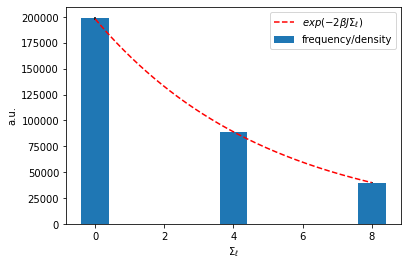

In [25]:
params = get_params(2)
K = 0.1

qc = ising(params, K, version=2)

counts = get_counts(qc, backend=sim_backend, shots=(8192 * 16))

print('qubits', qc.num_qubits)
print('d', len(qc.qregs[1]))
print('efficiency', get_efficiency(params, counts))

plot_boltzmann(params, K, counts)

npcounts = numpify_counts(counts)
out.create_dataset('1_1', npcounts.shape).write_direct(npcounts)

qc_empty = ising(params, K, namp=0, compute_norm=False, trans_only=True, measure=False, version=2)
qc_transpiled = transpile(qc_empty, backend=ibmq_backend, optimization_level=0)
print('ops', qc_transpiled.count_ops())

### Experiment 1-2: 2x2 simulation, controlled variant

norm 0.6980213376661545 namp 1
post-amp norm 0.7336656916292502
qubits 11
d 3
efficiency 0.5398635864257812
ops OrderedDict([('cx', 33), ('u3', 7)])


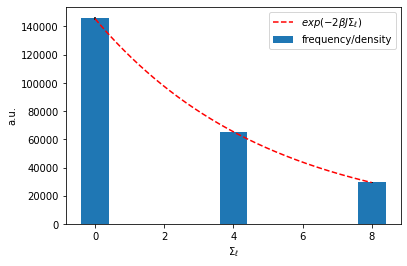

In [26]:
params = get_params(2)
K = 0.1

qc = ising(params, K, version=3)

counts = get_counts(qc, backend=sim_backend, shots=(8192 * 16))

print('qubits', qc.num_qubits)
print('d', len(qc.qregs[1]))
print('efficiency', get_efficiency(params, counts))

plot_boltzmann(params, K, counts)

npcounts = numpify_counts(counts)
out.create_dataset('1_2', npcounts.shape).write_direct(npcounts)

qc_empty = ising(params, K, namp=0, compute_norm=False, trans_only=True, measure=False, version=3)
qc_transpiled = transpile(qc_empty, backend=ibmq_backend, optimization_level=0)
print('ops', qc_transpiled.count_ops())

### Experiment 2-1: 3x3 simulation, direct variant

norm 0.2502079649378561 namp 3
post-amp norm 0.9801719335258668
qubits 13
d 3
efficiency 0.9618301391601562
ops OrderedDict([('u3', 4)])


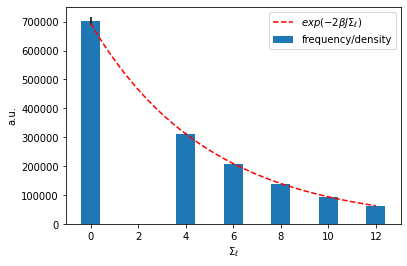

In [27]:
params = get_params(3)
K = 0.1

qc = ising(params, K, version=2)

counts = get_counts(qc, backend=sim_backend, shots=(8192 * 16))

print('qubits', qc.num_qubits)
print('d', len(qc.qregs[1]))
print('efficiency', get_efficiency(params, counts))

plot_boltzmann(params, K, counts)

npcounts = numpify_counts(counts)
out.create_dataset('2_1', npcounts.shape).write_direct(npcounts)

qc_empty = ising(params, K, namp=0, compute_norm=False, trans_only=True, measure=False, version=2)
qc_transpiled = transpile(qc_empty, backend=ibmq_backend, optimization_level=0)
print('ops', qc_transpiled.count_ops())

### Experiment 2-2: 3x3 simulation, controlled variant

norm 0.4267937013323098 namp 2
post-amp norm 0.8057085674523232
qubits 16
d 3
efficiency 0.6478500366210938
ops OrderedDict([('cx', 24), ('u3', 7)])


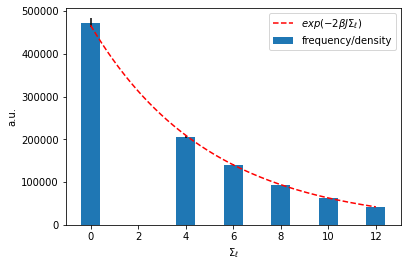

In [28]:
params = get_params(3)
K = 0.1

qc = ising(params, K, version=3)

counts = get_counts(qc, backend=sim_backend, shots=(8192 * 16))

print('qubits', qc.num_qubits)
print('d', len(qc.qregs[1]))
print('efficiency', get_efficiency(params, counts))

plot_boltzmann(params, K, counts)

npcounts = numpify_counts(counts)
out.create_dataset('2_2', npcounts.shape).write_direct(npcounts)

qc_empty = ising(params, K, namp=0, compute_norm=False, trans_only=True, measure=False, version=3)
qc_transpiled = transpile(qc_empty, backend=ibmq_backend, optimization_level=0)
print('ops', qc_transpiled.count_ops())

### Experiment 3-1: 4x4 simulation, direct variant

norm 0.12571997019934203 namp 6
post-amp norm 0.9976957135493637
qubits 22
d 5
efficiency 0.9952774047851562
ops OrderedDict([('u3', 6)])


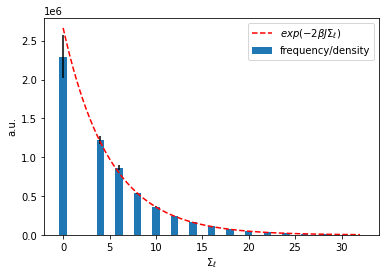

In [29]:
params = get_params(4)
K = 0.1

qc = ising(params, K, version=2)

counts = get_counts(qc, backend=sim_backend, shots=(8192 * 16))

print('qubits', qc.num_qubits)
print('d', len(qc.qregs[1]))
print('efficiency', get_efficiency(params, counts))

plot_boltzmann(params, K, counts)

npcounts = numpify_counts(counts)
out.create_dataset('3_1', npcounts.shape).write_direct(npcounts)

qc_empty = ising(params, K, namp=0, compute_norm=False, trans_only=True, measure=False, version=2)
qc_transpiled = transpile(qc_empty, backend=ibmq_backend, optimization_level=0)
print('ops', qc_transpiled.count_ops())

### Experiment 3-2: 4x4 simulation, controlled variant

norm 0.2189562767401905 namp 4
post-amp norm 0.9147508020742467
qubits 27
d 5
efficiency 0.8365478515625
ops OrderedDict([('cx', 43), ('u3', 11)])


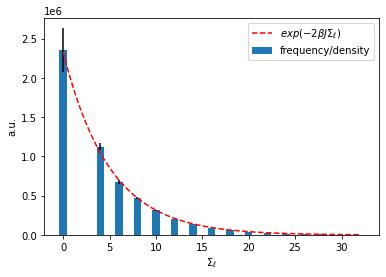

In [30]:
params = get_params(4)
K = 0.1

qc = ising(params, K, version=3)

counts = get_counts(qc, backend=sim_backend, shots=(8192 * 16))

print('qubits', qc.num_qubits)
print('d', len(qc.qregs[1]))
print('efficiency', get_efficiency(params, counts))

plot_boltzmann(params, K, counts)

npcounts = numpify_counts(counts)
out.create_dataset('3_2', npcounts.shape).write_direct(npcounts)

qc_empty = ising(params, K, namp=0, compute_norm=False, trans_only=True, measure=False, version=3)
qc_transpiled = transpile(qc_empty, backend=ibmq_backend, optimization_level=0)
print('ops', qc_transpiled.count_ops())

### Experiment 4-1: 2x2 IBMQ, direct variant

norm 0.4092152668501127 namp 0
post-amp norm 0.4092152668501127
efficiency 0.176513671875
ops OrderedDict([('cx', 676), ('u2', 156), ('u1', 154), ('u3', 98), ('measure', 7), ('barrier', 1)])


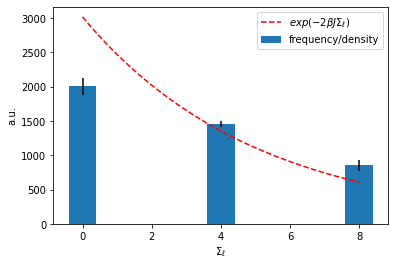

In [31]:
params = get_params(2)
K = 0.1

qc = ising(params, K, namp=0, version=2)
qc_transpiled = transpile(qc, backend=ibmq_backend, optimization_level=3)

counts = get_counts(qc_transpiled, backend=ibmq_backend, shots=8192)

print('efficiency', get_efficiency(params, counts))

plot_boltzmann(params, K, counts)

npcounts = numpify_counts(counts)
out.create_dataset('4_1', npcounts.shape).write_direct(npcounts)

print('ops', qc_transpiled.count_ops())

### Experiment 4-2: 2x2 IBMQ, controlled variant

norm 0.6980213376661545 namp 0
post-amp norm 0.6980213376661545
efficiency 0.2764892578125
ops OrderedDict([('cx', 498), ('u1', 162), ('u2', 117), ('u3', 89), ('measure', 7), ('barrier', 1)])


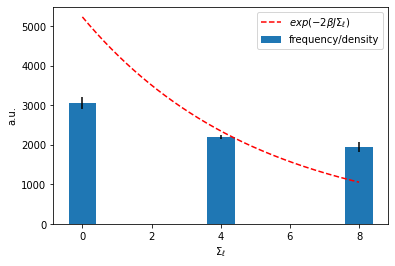

In [32]:
params = get_params(2)
K = 0.1

qc = ising(params, K, namp=0, version=3)
qc_transpiled = transpile(qc, backend=ibmq_backend, optimization_level=3)

counts = get_counts(qc_transpiled, backend=ibmq_backend, transpiled=True, shots=8192)

print('efficiency', get_efficiency(params, counts))

plot_boltzmann(params, K, counts)

npcounts = numpify_counts(counts)
out.create_dataset('4_2', npcounts.shape).write_direct(npcounts)

print('ops', qc_transpiled.count_ops())

### Experiment 5: Magnetization with 4x4 direct variant

norm 0.2021107067812753 namp 4
post-amp norm 0.9661795383630112
norm 0.007234911559917308 namp 109
post-amp norm 0.9999066609207728
norm 0.005482647464344397 namp 143
post-amp norm 0.9999962697872568


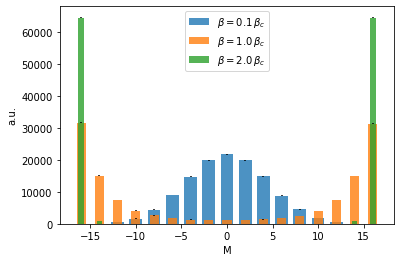

In [33]:
# Plot magnetization for several Ks
params = get_params(4)
Ks = [0.1 / 2.27, 1. / 2.27, 2. / 2.27]

fig, ax = plt.subplots()
x = np.arange(-params['n_spins'], params['n_spins'] + 1, 2)

for iK, K in enumerate(Ks):
    qc = ising(params, K, version=2)
    counts = get_counts(qc, backend=sim_backend, shots=(8192 * 16))
    
    npcounts = numpify_counts(counts)
    out.create_dataset('5_{}'.format(iK + 1), npcounts.shape).write_direct(npcounts)
    
    histogram = make_magnetization(params, counts)

    ax.bar(x, histogram, yerr=np.sqrt(histogram), width=(1.4 - 0.4 * iK), alpha=0.8, label=r'$\beta={:.1f}\, \beta_{{c}}$'.format(K * 2.27))

ax.legend()
ax.set_xlabel('M')
ax.set_ylabel('a.u.')
fig.show(warn=False)

In [34]:
out.close()